<a href="https://colab.research.google.com/github/shwets1503/Audio-Classification/blob/master/BDS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#In case I want to load data into colab itself
#!cp -r '../content/drive/My Drive/FSDKaggle2018.audio_train/' /content

In [0]:
#Importing libraries
import numpy as np 
import pandas as pd

import librosa 
import librosa.display

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline
matplotlib.style.use('ggplot')

from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Reading meta data file
train = pd.read_csv('../content/drive/My Drive/esc50.csv')

In [0]:
#train = train.drop(['esc10', 'src_file', 'take', 'fold'], axis =1)

In [0]:
#train = train[['filename', 'category', 'target']]

In [148]:
train.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [150]:
print("Number of training examples=", train.shape[0], "  Number of classes=", 
      len(train['category'].unique()))

Number of training examples= 2000   Number of classes= 50


In [0]:
#train.category.value_counts()

### Checking for number of channels, bit depth and sample rates of files

In [0]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [0]:
#from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in train.iterrows():
    
    file_name = os.path.join(os.path.abspath('/content/drive/My Drive/audio/') +'/',str(row["filename"]))
    
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [167]:
#num of channels 
print(audiodf.num_channels.value_counts(normalize=True))

1    1.0
Name: num_channels, dtype: float64


In [168]:
#sample rates 
print(audiodf.sample_rate.value_counts(normalize=True))

44100    1.0
Name: sample_rate, dtype: float64


In [169]:
#bit depth
print(audiodf.bit_depth.value_counts(normalize=True))

16    1.0
Name: bit_depth, dtype: float64


### Plotting times series, fourier transform and filter bank coefficients plots

In [0]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=4, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(4):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [0]:
classes = list(np.unique(train.category))

In [0]:
def calc_fft(y, rate):
  n = len(y)
  freq = np.fft.rfftfreq(n, d = 1/rate)
  Y = abs(np.fft.rfft(y)/n)
  return(Y, freq)

In [0]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

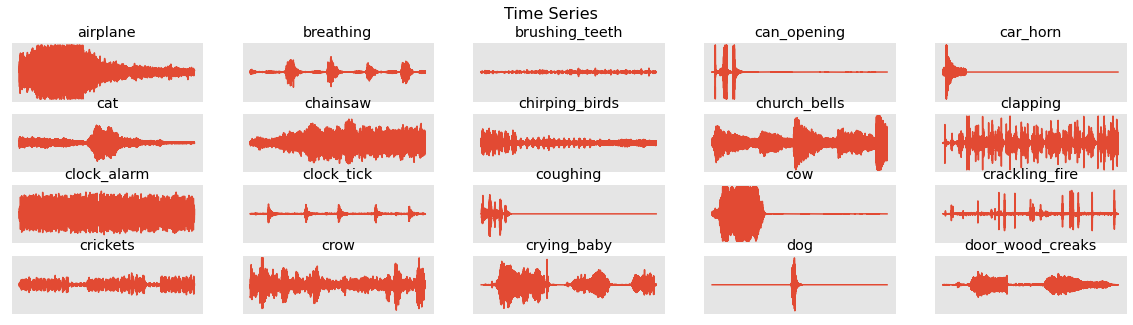

In [215]:
for c in classes: 
  wav_file = train[train.category == c].iloc[0,0]
  signal, rate = librosa.load('/content/drive/My Drive/audio/' +wav_file, sr = 44100)
  
  signals[c] = signal
  fft[c] = calc_fft(signal, rate)
  

  bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
  fbank[c] = bank
  #mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft= 1103).T
  #mfccs[c] = mel

plot_signals(signals)
plt.show();

#plot_mfcc(mfccs)
#plt.show()

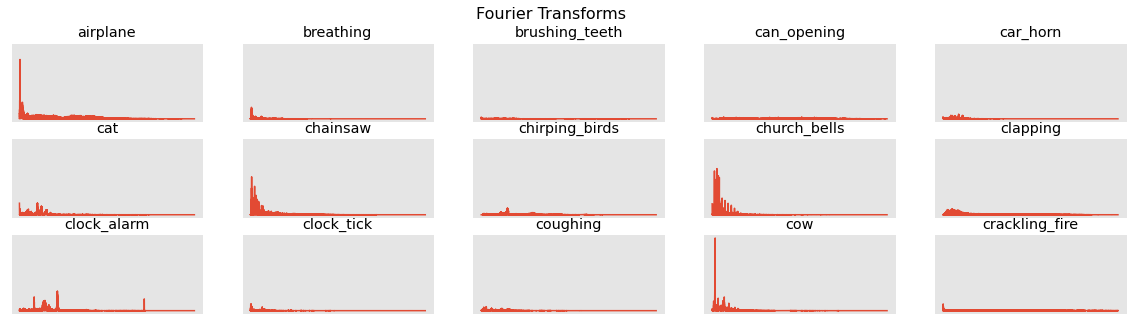

In [175]:
plot_fft(fft)
plt.show();

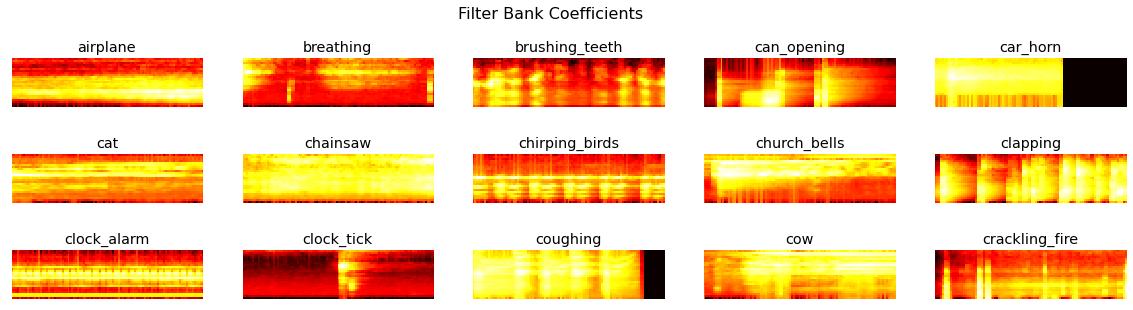

In [176]:
plot_fbank(fbank)
plt.show;

### Analysing Audio Data

In [181]:
# Using IPython.display.Audio to play the audio files so we can inspect aurally
ipd.Audio('../content/drive/My Drive/audio/1-137-A-32.wav')

In [0]:
filename = '/content/drive/My Drive/audio/1-137-A-32.wav'

In [179]:
#Sample rate conversion
librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 44100
Librosa sample rate: 22050


In [180]:
#Bit depth conversion
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -17080 to 12341
Librosa audio file min~max range: -0.5164941 to 0.35505846


In [182]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 216)


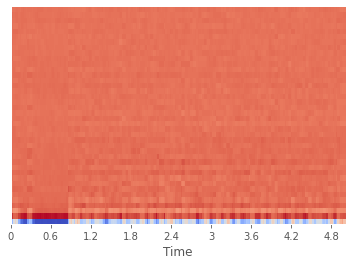

In [183]:
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [0]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [186]:
# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/content/drive/My Drive/audio/'

metadata = pd.read_csv('../content/drive/My Drive/esc50.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath)+'/',str(row["filename"]))
    print(file_name)
    
    class_label = row["category"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

/content/drive/My Drive/audio/1-100032-A-0.wav
/content/drive/My Drive/audio/1-100038-A-14.wav
/content/drive/My Drive/audio/1-100210-A-36.wav
/content/drive/My Drive/audio/1-100210-B-36.wav
/content/drive/My Drive/audio/1-101296-A-19.wav
/content/drive/My Drive/audio/1-101296-B-19.wav
/content/drive/My Drive/audio/1-101336-A-30.wav
/content/drive/My Drive/audio/1-101404-A-34.wav
/content/drive/My Drive/audio/1-103298-A-9.wav
/content/drive/My Drive/audio/1-103995-A-30.wav
/content/drive/My Drive/audio/1-103999-A-30.wav
/content/drive/My Drive/audio/1-104089-A-22.wav
/content/drive/My Drive/audio/1-104089-B-22.wav
/content/drive/My Drive/audio/1-105224-A-22.wav
/content/drive/My Drive/audio/1-110389-A-0.wav
/content/drive/My Drive/audio/1-110537-A-22.wav
/content/drive/My Drive/audio/1-115521-A-19.wav
/content/drive/My Drive/audio/1-115545-A-48.wav
/content/drive/My Drive/audio/1-115545-B-48.wav
/content/drive/My Drive/audio/1-115545-C-48.wav
/content/drive/My Drive/audio/1-115546-A-48

In [188]:
featuresdf.head()

,feature,class_label
0,"[-601.344944808394, 5.2614082261637884, -9.065...",dog
1,"[-200.65909506056875, 12.515456415611007, -69....",chirping_birds
2,"[7.545552539995939, 69.50337381031625, -21.425...",vacuum_cleaner
3,"[8.940391242994831, 67.527899346432, -19.81801...",vacuum_cleaner
4,"[-428.37644414305834, 132.65819143400066, 31.1...",thunderstorm


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [0]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [193]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

In [198]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 0s 100us/step - loss: 0.8154 - accuracy: 0.7625 - val_loss: 3.0401 - val_accuracy: 0.4675

Epoch 00001: val_loss improved from inf to 3.04014, saving model to /content/drive/My Drive/weights.best.basic_mlp.hdf5
Epoch 2/1000
1600/1600 [==============================] - 0s 93us/step - loss: 0.8749 - accuracy: 0.7581 - val_loss: 3.0105 - val_accuracy: 0.4825

Epoch 00002: val_loss improved from 3.04014 to 3.01046, saving model to /content/drive/My Drive/weights.best.basic_mlp.hdf5
Epoch 3/1000
1600/1600 [==============================] - 0s 97us/step - loss: 0.8340 - accuracy: 0.7644 - val_loss: 2.9609 - val_accuracy: 0.4925

Epoch 00003: val_loss improved from 3.01046 to 2.96085, saving model to /content/drive/My Drive/weights.best.basic_mlp.hdf5
Epoch 4/1000
1600/1600 [==============================] - 0s 94us/step - loss: 0.8252 - accuracy: 0.7631 - val_loss: 2.9270 - val_accuracy: 

In [197]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9456250071525574
Testing Accuracy:  0.4749999940395355


In [0]:
def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [0]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [210]:
# Class: Dog

filename =  '/content/drive/My Drive/audio/1-137296-A-16.wav'
print_prediction(filename)

The predicted class is: wind 

airplane 		 :  0.00000000000010518389409247194677
breathing 		 :  0.00000000000000000000000000000000
brushing_teeth 		 :  0.00000000000000000000000000003343
can_opening 		 :  0.00000000000000000000000000000000
car_horn 		 :  0.00000000000000000000000000003743
cat 		 :  0.00000000000000000000000000000000
chainsaw 		 :  0.00000000000000000000002898920570
chirping_birds 		 :  0.00000000042150208323654680953041
church_bells 		 :  0.00000000000000000000000000002297
clapping 		 :  0.00000000000000000000000000000000
clock_alarm 		 :  0.00000000000000000000000000000000
clock_tick 		 :  0.00000000000000000000005966971024
coughing 		 :  0.00000000000000000000000000000000
cow 		 :  0.00000000000000000000000000000000
crackling_fire 		 :  0.00000000000000015031712703259811
crickets 		 :  0.00000000000000000000254995064367
crow 		 :  0.00000000000000000000000000000000
crying_baby 		 :  0.00000000000000000000000000000000
dog 		 :  0.00000000000000000000000000000000
door

In [218]:
#Unknown file
filename =  '/content/drive/My Drive/Horn Honk-SoundBible.com-1162546405.wav'
print_prediction(filename)

The predicted class is: car_horn 

airplane 		 :  0.00000000000000004872939517395607
breathing 		 :  0.00000000000000000000002717856481
brushing_teeth 		 :  0.00000000000000000000000000002649
can_opening 		 :  0.00000000000000000000000000000000
car_horn 		 :  1.00000000000000000000000000000000
cat 		 :  0.00000000000000000000000002863406
chainsaw 		 :  0.00000000000000000000000000000000
chirping_birds 		 :  0.00000000000000000000000000000001
church_bells 		 :  0.00000000000000000000000012233561
clapping 		 :  0.00000000000000000000000000000000
clock_alarm 		 :  0.00000000000000000000000000000000
clock_tick 		 :  0.00000000000000000000007558627904
coughing 		 :  0.00000000000000000000000000000000
cow 		 :  0.00000000000000000000000000757611
crackling_fire 		 :  0.00000000000000000000000000000000
crickets 		 :  0.00000000000000000000000000000000
crow 		 :  0.00000000000000000000000000000000
crying_baby 		 :  0.00000000000000000000000000000736
dog 		 :  0.00000000000000000000000000000000


In [222]:
filename =  '/content/drive/My Drive/Tornado_Siren_II-Delilah-747233690.wav'
print_prediction(filename)

The predicted class is: hen 

airplane 		 :  0.00000001283081019209930673241615
breathing 		 :  0.00070997851435095071792602539062
brushing_teeth 		 :  0.00067640683846548199653625488281
can_opening 		 :  0.00000123294250897743040695786476
car_horn 		 :  0.00000027062620233664347324520350
cat 		 :  0.00000897913832886843010783195496
chainsaw 		 :  0.00000000492015406194923343718983
chirping_birds 		 :  0.00000937623099162010475993156433
church_bells 		 :  0.00001000119300442747771739959717
clapping 		 :  0.00000951415313465986400842666626
clock_alarm 		 :  0.00001926968070620205253362655640
clock_tick 		 :  0.00048763360246084630489349365234
coughing 		 :  0.00000000042453535131770081534341
cow 		 :  0.00000003621839539391658036038280
crackling_fire 		 :  0.00000000000000898098191952009794
crickets 		 :  0.00003391562495380640029907226562
crow 		 :  0.00000000023216784050816841045162
crying_baby 		 :  0.08442691713571548461914062500000
dog 		 :  0.00457599246874451637268066406250
door_